In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("personalized_learning_dataset.csv")

In [48]:
df = df[['Age', 'Education_Level', 'Course_Name', 'Time_Spent_on_Videos', 'Quiz_Scores', 'Final_Exam_Score']]

df.dropna(inplace=True)

In [49]:
scaler = MinMaxScaler()
df['Time_Spent_on_Videos_Scaled'] = scaler.fit_transform(df[['Time_Spent_on_Videos']])

df['Efficiency_Score'] = (0.4 * df['Final_Exam_Score'] +
                          0.4 * df['Quiz_Scores'] +
                          0.2 * df['Time_Spent_on_Videos_Scaled'] * 100)  

In [50]:
df['Proficiency_Level'] = pd.qcut(df['Efficiency_Score'], q=3, labels=['beginner', 'intermediate', 'advanced'])

features = ['Age', 'Education_Level', 'Course_Name', 'Time_Spent_on_Videos', 'Quiz_Scores', 'Final_Exam_Score']
target = 'Proficiency_Level'
X = df[features]
y = df[target]

X_encoded = pd.get_dummies(X, columns=['Education_Level', 'Course_Name'], drop_first=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.05, random_state=42)

cart_classifier = DecisionTreeClassifier(random_state=42)
cart_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [52]:
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_classifier = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [53]:
y_pred = best_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

    advanced       0.96      0.93      0.94       175
    beginner       0.96      0.97      0.97       166
intermediate       0.90      0.92      0.91       159

    accuracy                           0.94       500
   macro avg       0.94      0.94      0.94       500
weighted avg       0.94      0.94      0.94       500

Accuracy: 0.94


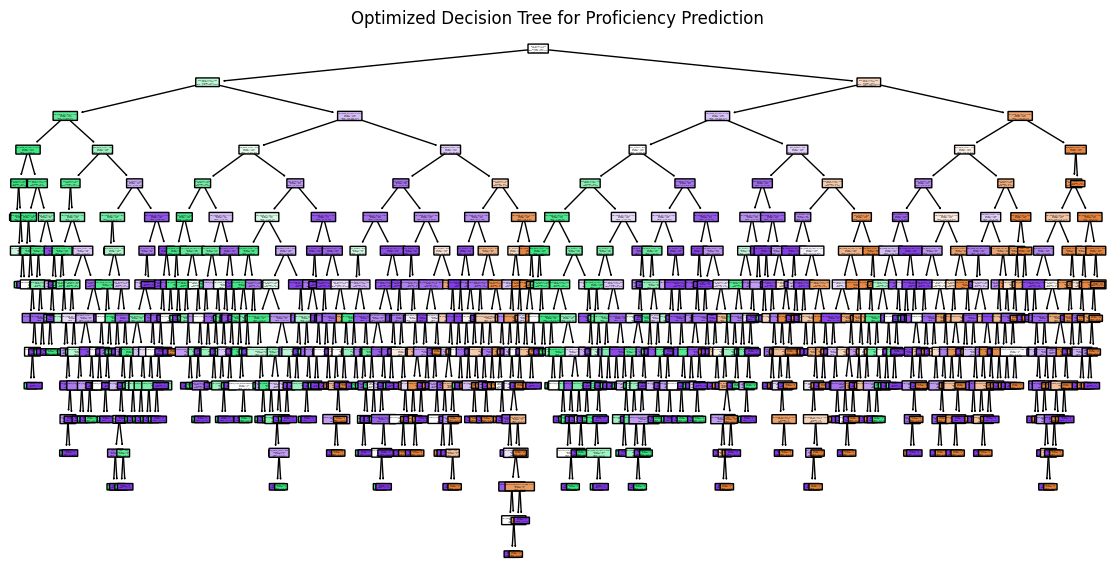

In [54]:
plt.figure(figsize=(14, 7))
plot_tree(best_classifier, feature_names=X_encoded.columns, class_names=best_classifier.classes_, filled=True, rounded=True)
plt.title("Optimized Decision Tree for Proficiency Prediction")
plt.show()


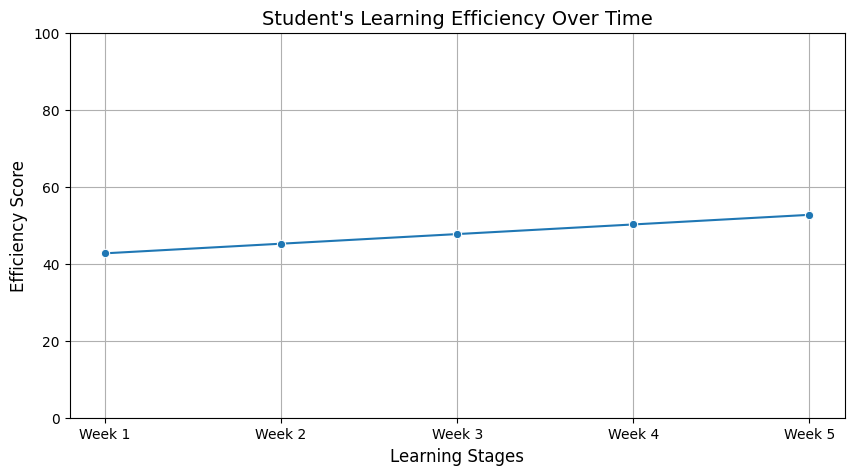

In [55]:
student_data = {
    'Quiz Scores': 71,
    'Final Exam Score': 75,
    'Assignment Completion Rate': 89,
    'Time Spent on Videos': 17,
    'Forum Participation': 2
}

normalized_time_spent = student_data['Time Spent on Videos'] / 2 
normalized_forum_participation = student_data['Forum Participation'] * 10 

efficiency_scores = [
    (student_data['Quiz Scores'] + student_data['Final Exam Score'] + 
     student_data['Assignment Completion Rate'] + normalized_time_spent + 
     normalized_forum_participation) / 5
]

efficiency_trend = np.linspace(efficiency_scores[0] - 10, efficiency_scores[0], 5)

performance_df = pd.DataFrame({
    'Stage': ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5'],
    'Efficiency': efficiency_trend
})

plt.figure(figsize=(10, 5))
sns.lineplot(x='Stage', y='Efficiency', data=performance_df, marker='o', linestyle='-')

plt.title("Student's Learning Efficiency Over Time", fontsize=14)
plt.xlabel("Learning Stages", fontsize=12)
plt.ylabel("Efficiency Score", fontsize=12)
plt.ylim(0, 100)
plt.grid(True)

plt.show()


In [56]:
def predict_proficiency(age, education_level, course_name, time_spent, quiz_scores, final_exam_score):
    input_dict = {
        'Age': [age],
        'Time_Spent_on_Videos': [time_spent],
        'Quiz_Scores': [quiz_scores],
        'Final_Exam_Score': [final_exam_score],
        'Education_Level': [education_level],
        'Course_Name': [course_name]
    }
    input_df = pd.DataFrame(input_dict)
    
    input_encoded = pd.get_dummies(input_df, columns=['Education_Level', 'Course_Name'], drop_first=True)
    
    for col in X_encoded.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
            
    input_encoded = input_encoded[X_encoded.columns]
    
    prediction = best_classifier.predict(input_encoded)[0]
    return prediction

In [57]:
sample_prediction = predict_proficiency(
    age=15,
    education_level="High School",  
    course_name="Machine Learning", 
    time_spent=17,
    quiz_scores=71,
    final_exam_score=75
)

print(f"\nPredicted Proficiency Level: {sample_prediction}")


Predicted Proficiency Level: intermediate
